In [1]:
import os, sys
import general_config 
print(general_config.ROOTDIR)
sys.path.append(general_config.ROOTDIR)

import numpy as np
import matplotlib.pyplot as plt

D:/Desktop@D/xai_basic


# Setting up for training using Pytorch
We use ResNet as an example: <br>
1. First, replace the final layer of ResNet with a fully connected layer to adjust to the dataset which has only 10 classes.<br>
2. Setup optimzer and loss. Here, we use adam optimizer and cross entropy losses <br>

<span style='color:red'>Note:</span> In our real experiment, more adjustment to ResNet is needed, since we need to ensure it is compatible with Captum. Besides, we experimented with AlexNet and VGG too.

In [2]:
# 1.
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as mod
import torch.utils.data as data

class Resnet34_adjusted(nn.Module):
    def __init__(self):
        super(Resnet34_adjusted, self).__init__()
        self.backbone = mod.resnet34(pretrained=True)
        self.fc = nn.Conv2d(512,10,1)
    def forward(self, x):
        for i, m in enumerate(self.backbone.children()):
            if i==9: break # x = x.view(1,-1)
            x = m(x)
            # print(i, x.shape)
        x = self.fc(x)
        x = x.squeeze(3).squeeze(2)
        return x
    
this_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")     
net = Resnet34_adjusted()
net.to(device=this_device)

Resnet34_adjusted(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [3]:
# 2.
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999),weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

# Training and Data Shards
pipeline. objgen. random_simple_gen_implemented <b>TenClassesPyIO()</b> class to make use of pytorch <i>Dataset</i> object for convenient training. We define a function to load this dataset from the shards that we have prepared in tutorial_0002.<br><br>

In our actual experiment, <b>load_dataset_from_a_shard()</b> is allowed to adjust image size.

In [4]:
from pipeline.objgen.random_simple_gen_implemented import TenClassesPyIO
def load_dataset_from_a_shard(k, CACHE_FOLDER_DIR, DATA_NAME):
    this_dataset = TenClassesPyIO()        
    shard_dir = os.path.join(CACHE_FOLDER_DIR, '%s.%s.%s'%(str(DATA_NAME),str(k),'shard'))    
    
    # tv setting is not important here; it's to handle printing
    this_dataset = this_dataset.load_pickled_data(shard_dir, tv=(1,0,1000)) 
    this_dataset.x = np.array(this_dataset.x) # original shape (N, C, H, W)
    return this_dataset

From tutorial_0002, we have prepared 4 training shards, each containing 12 samples. Since we set batch size to 4 in the code below, the 12 samples are bundles into 3 batches of 4, hence we see 3 iterations per shard. For the complete training process we use in the experiment, see for example pipeline.training.resnet34_ten_classes.py.

In [5]:
N_epoch = 12
N_training_shards = 4
CACHE_FOLDER_DIR = 'temp'
DATA_NAME = 'demo_training_data'

losses = []
for epoch in range(N_epoch):
    for n_th_shard_iter, k in enumerate(list(range(1,1+N_training_shards))):
        this_dataset = load_dataset_from_a_shard(k, CACHE_FOLDER_DIR, DATA_NAME)
        trainloader = data.DataLoader(dataset=this_dataset, shuffle=True, batch_size=4)        
        n = len(trainloader)
        for i, this_data in enumerate(trainloader, 0):
            update_str = 'epoch:%s. shard:%s/%s. iter:%s/%s'%(str(epoch),str(k),str(N_training_shards), str(i+1),str(n))
            print('%-96s'%(str(update_str)), end='\r')
            net.train()
            optimizer.zero_grad()
            x, y0 = this_data
            x = x.to(torch.float).to(this_device)
            y0 = y0.to(this_device)
            y = net(x)
            loss = criterion(y,y0.to(torch.long))
            loss.backward()            
            optimizer.step()
            losses.append(loss.item())
    print()

epoch:0. shard:4/4. iter:3/3                                                                    
epoch:1. shard:4/4. iter:3/3                                                                    
epoch:2. shard:4/4. iter:3/3                                                                    
epoch:3. shard:4/4. iter:3/3                                                                    
epoch:4. shard:4/4. iter:3/3                                                                    
epoch:5. shard:4/4. iter:3/3                                                                    
epoch:6. shard:4/4. iter:3/3                                                                    
epoch:7. shard:4/4. iter:3/3                                                                    
epoch:8. shard:4/4. iter:3/3                                                                    
epoch:9. shard:4/4. iter:3/3                                                                    
epoch:10. shard:4/4. iter:3/3 

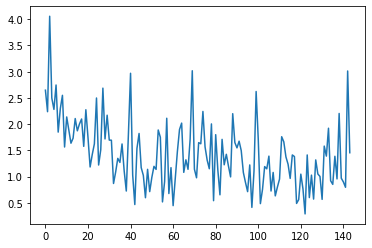

In [6]:
%matplotlib inline
plt.figure()
plt.plot(losses)